## **LSTM for Cloud Resource Metrics Forecasting**

**The model is designed to forecast key AWS resource metrics (EC2, RDS, and ECS CPU utilization) by leveraging historical cloud monitoring data.**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import math
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

1. Load and pre process data

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_and_preprocess(file_path):
    df = pd.read_csv(file_path)
    print(f"Loading data from {file_path}")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    df = df.set_index('timestamp')
    df = df.sort_index()

    # Handling missing values
    df = df.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

    # Smoothing with adaptive window
    for col in df.columns:
        if 'CPUUtilization' in col:
            rolling_window = max(3, min(24, int(len(df)/100)))
            df[col] = df[col].rolling(window=rolling_window, min_periods=1, center=True).mean()
            df[col] = df[col].clip(upper=100)

    print(f"Shape after preprocessing: {df.shape}")
    print(f"Index has NaT: {df.index.isna().any()}")
    return df

2. Feature engineering with feature importance analysis 

- Create additional features (lags, differences, rolling stats, ratios, time encodings) and select top features using RandomForest importance.

In [ ]:
def add_features(df, service_type):
    if service_type == 'ec2':
        cpu_col = 'EC2_CPUUtilization'
        memory_col = 'EC2_MemoryUtilization'
        network_col = 'EC2_NetworkIn'
        disk_col = 'EC2_DiskWriteOps'
    elif service_type == 'rds':
        cpu_col = 'RDS_CPUUtilization'
        memory_col = 'RDS_FreeableMemory'
        conn_col = 'RDS_DatabaseConnections'
        io_col = 'RDS_WriteIOPS'
    elif service_type == 'ecs':
        cpu_col = 'ECS_CPUUtilization'
        memory_col = 'ECS_MemoryUtilization'
        task_col = 'ECS_RunningTaskCount'
        network_col = 'ECS_NetworkIn'

    # Lag features with different time scales
    for i in [1, 3, 6, 12, 24]:
        df[f'{cpu_col}_lag_{i}'] = df[cpu_col].shift(i)

    # Differencing features
    for i in [1, 3, 6]:
        df[f'{cpu_col}_diff_{i}'] = df[cpu_col].diff(i)

    # Rolling features
    for window in ['1H', '3H', '6H', '12H', '24H']:
        df[f'{cpu_col}_roll_{window}_mean'] = df[cpu_col].rolling(window, min_periods=1).mean()
        df[f'{cpu_col}_roll_{window}_std'] = df[cpu_col].rolling(window, min_periods=1).std()

    # Percentile features
    for window in ['6H', '24H']:
        for q in [0.1, 0.25, 0.5, 0.75, 0.9]:
            df[f'{cpu_col}_q{q*100}_{window}'] = df[cpu_col].rolling(window, min_periods=1).quantile(q)

    # Service-specific features
    if service_type == 'ec2':
        df['EC2_CPU_Memory_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[memory_col]) + 1e-8)
        df['EC2_CPU_Network_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[network_col]) + 1e-8)
        df['EC2_CPU_Disk_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[disk_col]) + 1e-8)
    elif service_type == 'rds':
        df['RDS_Memory_Usage_Estimate'] = 100 - (df[memory_col] / df[memory_col].max() * 100)
        df['RDS_CPU_Memory_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df['RDS_Memory_Usage_Estimate']) + 1e-8)
        df['RDS_CPU_Conn_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[conn_col]) + 1e-8)
        df['RDS_CPU_IO_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[io_col]) + 1e-8)
    elif service_type == 'ecs':
        df['ECS_CPU_Memory_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[memory_col]) + 1e-8)
        df['ECS_CPU_Task_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[task_col]) + 1e-8)
        df['ECS_CPU_Network_Ratio'] = np.log1p(df[cpu_col]) / (np.log1p(df[network_col]) + 1e-8)

    # Time features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

    df = df.drop(columns=['hour', 'day_of_week', 'day_of_month', 'month'])

    original_len = len(df)
    df = df.dropna()
    print(f"Dropped {original_len - len(df)} rows containing NaN values in data columns")

    if df.index.isna().any():
        print(f"Found NaT in index. Cleaning index...")
        df = df[~df.index.isna()]
        print(f"Dropped rows with NaT in index. New shape: {df.shape}")
        print

    # Feature importance analysis
    print("Performing feature importance analysis...")
    X = df.drop(columns=[cpu_col])
    y = df[cpu_col]

    # Train-test split for feature importance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    print("Top most important features:")
    print(importance.head(20))

    # Selecting top features
    top_features = importance['feature'].head(20).values
    corr_matrix = df[top_features].corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    selected_features = [f for f in top_features if f not in to_drop]

    selected_columns = list(selected_features) + [cpu_col]
    df = df[selected_columns]

    with open(f'{service_type}_feature_columns.pkl', 'wb') as f:
        pickle.dump(list(df.columns), f)

    print(f"Final DataFrame shape after feature selection: {df.shape}")
    print(f"Selected features: {selected_features}")
    return df

3. Dataset class and LSTM model

- Define a custom PyTorch Dataset and prepare time series data for LSTM (sequences, scaling, train/test split)

- Define a LSTM model with attention mechanism for time series prediction.

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.augment and torch.rand(1) > 0.5:
            noise = torch.randn_like(self.X[idx]) * 0.01
            return self.X[idx] + noise, self.y[idx]
        return self.X[idx], self.y[idx]

# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)

        self.ln = nn.LayerNorm(hidden_size)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                elif 'attention' in name or 'fc' in name:
                    if len(param.shape) >= 2:
                        nn.init.xavier_uniform_(param.data)
                    else:
                        nn.init.uniform_(param.data, -0.1, 0.1)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
                if 'lstm' in name and 'bias_hh' in name:
                    n = param.size(0)
                    param.data[self.hidden_size:2*self.hidden_size].fill_(1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.ln(lstm_out)

        # Attention mechanism
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(lstm_out * attn_weights, dim=1)

        out = self.fc1(context)
        out = self.ln2(out)
        out = nn.functional.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        # Sigmoid activation to keep output between 0 and 1
        out = torch.sigmoid(out)
        return out

4. Data preperation

In [ ]:
def prepare_data_for_lstm(df, target_col, sequence_length=24):
    if df.index.isna().any():
        raise ValueError("Index contains NaT values. Please clean the DataFrame before proceeding.")

    # Separate target and features
    target_data = df[target_col].values.reshape(-1, 1)
    features = df.drop(columns=[target_col])

    feature_scaler = RobustScaler(quantile_range=(5, 95)) 
    target_scaler = MinMaxScaler(feature_range=(0, 1))    

    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target_data)

    # Create sequences
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(scaled_features[i:i+sequence_length])
        y.append(scaled_target[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Train-test split 
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train, y_train, X_test, y_test, feature_scaler, target_scaler

5. Training function

- Train the LSTM model with early stopping and learning rate scheduling.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        if scheduler:
            scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(torch.load('best_model.pth'))
                break

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')

    return model, train_losses, val_losses


6. Evaluation

In [ ]:
def evaluate_model(model, test_loader, criterion, target_scaler):
    model.eval()
    predictions = []
    actuals = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Unscaling
    actuals_unscaled = target_scaler.inverse_transform(actuals.reshape(-1, 1))
    predictions_unscaled = target_scaler.inverse_transform(predictions.reshape(-1, 1))

    # Calculate metrics
    mae = mean_absolute_error(actuals_unscaled, predictions_unscaled)
    rmse = np.sqrt(mean_squared_error(actuals_unscaled, predictions_unscaled))
    smape = 100 * np.mean(2 * np.abs(predictions_unscaled - actuals_unscaled) /
                         (np.abs(predictions_unscaled) + np.abs(actuals_unscaled) + 1e-8))

    ss_res = np.sum((actuals_unscaled - predictions_unscaled) ** 2)
    ss_tot = np.sum((actuals_unscaled - np.mean(actuals_unscaled)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))

    print(f"Test Loss: {avg_test_loss:.6f}")
    print(f"MAE: {mae:.4f}%, RMSE: {rmse:.4f}%, SMAPE: {smape:.4f}%, R²: {r2:.4f}")

    return avg_test_loss, predictions, actuals, {
        'mae': mae, 'rmse': rmse, 'smape': smape, 'r2': r2,
        'predictions_unscaled': predictions_unscaled,
        'actuals_unscaled': actuals_unscaled
    }

7. Plotting function

In [ ]:
def plot_results(train_losses, val_losses, predictions, actuals, service_name, metrics):
    plt.figure(figsize=(18, 12))

    # Loss plots
    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{service_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Predictions vs actuals plots
    plt.subplot(3, 1, 2)
    plt.plot(actuals[:500], label='Actual', alpha=0.7, linewidth=1)
    plt.plot(predictions[:500], label='Predicted', alpha=0.7, linewidth=1)
    plt.title(f'{service_name} - Predictions vs Actuals\nMAE: {metrics["mae"]:.2f}%, RMSE: {metrics["rmse"]:.2f}%, SMAPE: {metrics["smape"]:.2f}%, R²: {metrics["r2"]:.4f}')
    plt.xlabel('Time Step')
    plt.ylabel('CPU Utilization (Scaled)')
    plt.legend()
    plt.grid(True)

    # Error distribution plots
    plt.subplot(3, 1, 3)
    errors = metrics['predictions_unscaled'] - metrics['actuals_unscaled']
    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'{service_name} - Error Distribution\nMean Error: {np.mean(errors):.2f}%, Std: {np.std(errors):.2f}%')
    plt.xlabel('Prediction Error (%)')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{service_name}_results.png', dpi=300)
    plt.show()

8. Forecasting function

In [ ]:
def forecast_future(model, last_sequence, feature_scaler, target_scaler, steps_ahead=24):
    model.eval()
    future_predictions = []
    current_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    alpha = 0.3 
    smoothed_pred = None

    with torch.no_grad():
        for _ in range(steps_ahead):
            next_pred = model(current_sequence).item()

            if smoothed_pred is None:
                smoothed_pred = next_pred
            else:
                smoothed_pred = alpha * next_pred + (1 - alpha) * smoothed_pred

            future_predictions.append(smoothed_pred)

            new_sequence = current_sequence.clone()
            new_sequence[0, :-1] = current_sequence[0, 1:]

            new_input = np.zeros((1, last_sequence.shape[1]))
            new_input[0, 0] = smoothed_pred 

            new_input_scaled = feature_scaler.transform(new_input)
            new_sequence[0, -1] = torch.tensor(new_input_scaled, dtype=torch.float32).to(device)
            current_sequence = new_sequence

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions_unscaled = target_scaler.inverse_transform(future_predictions)

    return future_predictions_unscaled.flatten()

9. Main pipeline

- Start the full workflow: preprocess, train, evaluate, save model/scalers, and forecast.

Using device: cuda

Processing EC2 data...
Loading data from /content/ec2_metrics.csv
Shape after preprocessing: (43200, 4)
Index has NaT: False
Dropped 24 rows containing NaN values in data columns
Performing feature importance analysis...
Top most important features:
                             feature  importance
3           EC2_CPUUtilization_lag_1    0.963841
8          EC2_CPUUtilization_diff_1    0.035903
10         EC2_CPUUtilization_diff_6    0.000060
9          EC2_CPUUtilization_diff_3    0.000014
11   EC2_CPUUtilization_roll_1H_mean    0.000008
12    EC2_CPUUtilization_roll_1H_std    0.000008
5           EC2_CPUUtilization_lag_6    0.000008
14    EC2_CPUUtilization_roll_3H_std    0.000008
18   EC2_CPUUtilization_roll_12H_std    0.000007
4           EC2_CPUUtilization_lag_3    0.000006
16    EC2_CPUUtilization_roll_6H_std    0.000006
38                  day_of_month_sin    0.000006
20   EC2_CPUUtilization_roll_24H_std    0.000006
17  EC2_CPUUtilization_roll_12H_mean    0.00

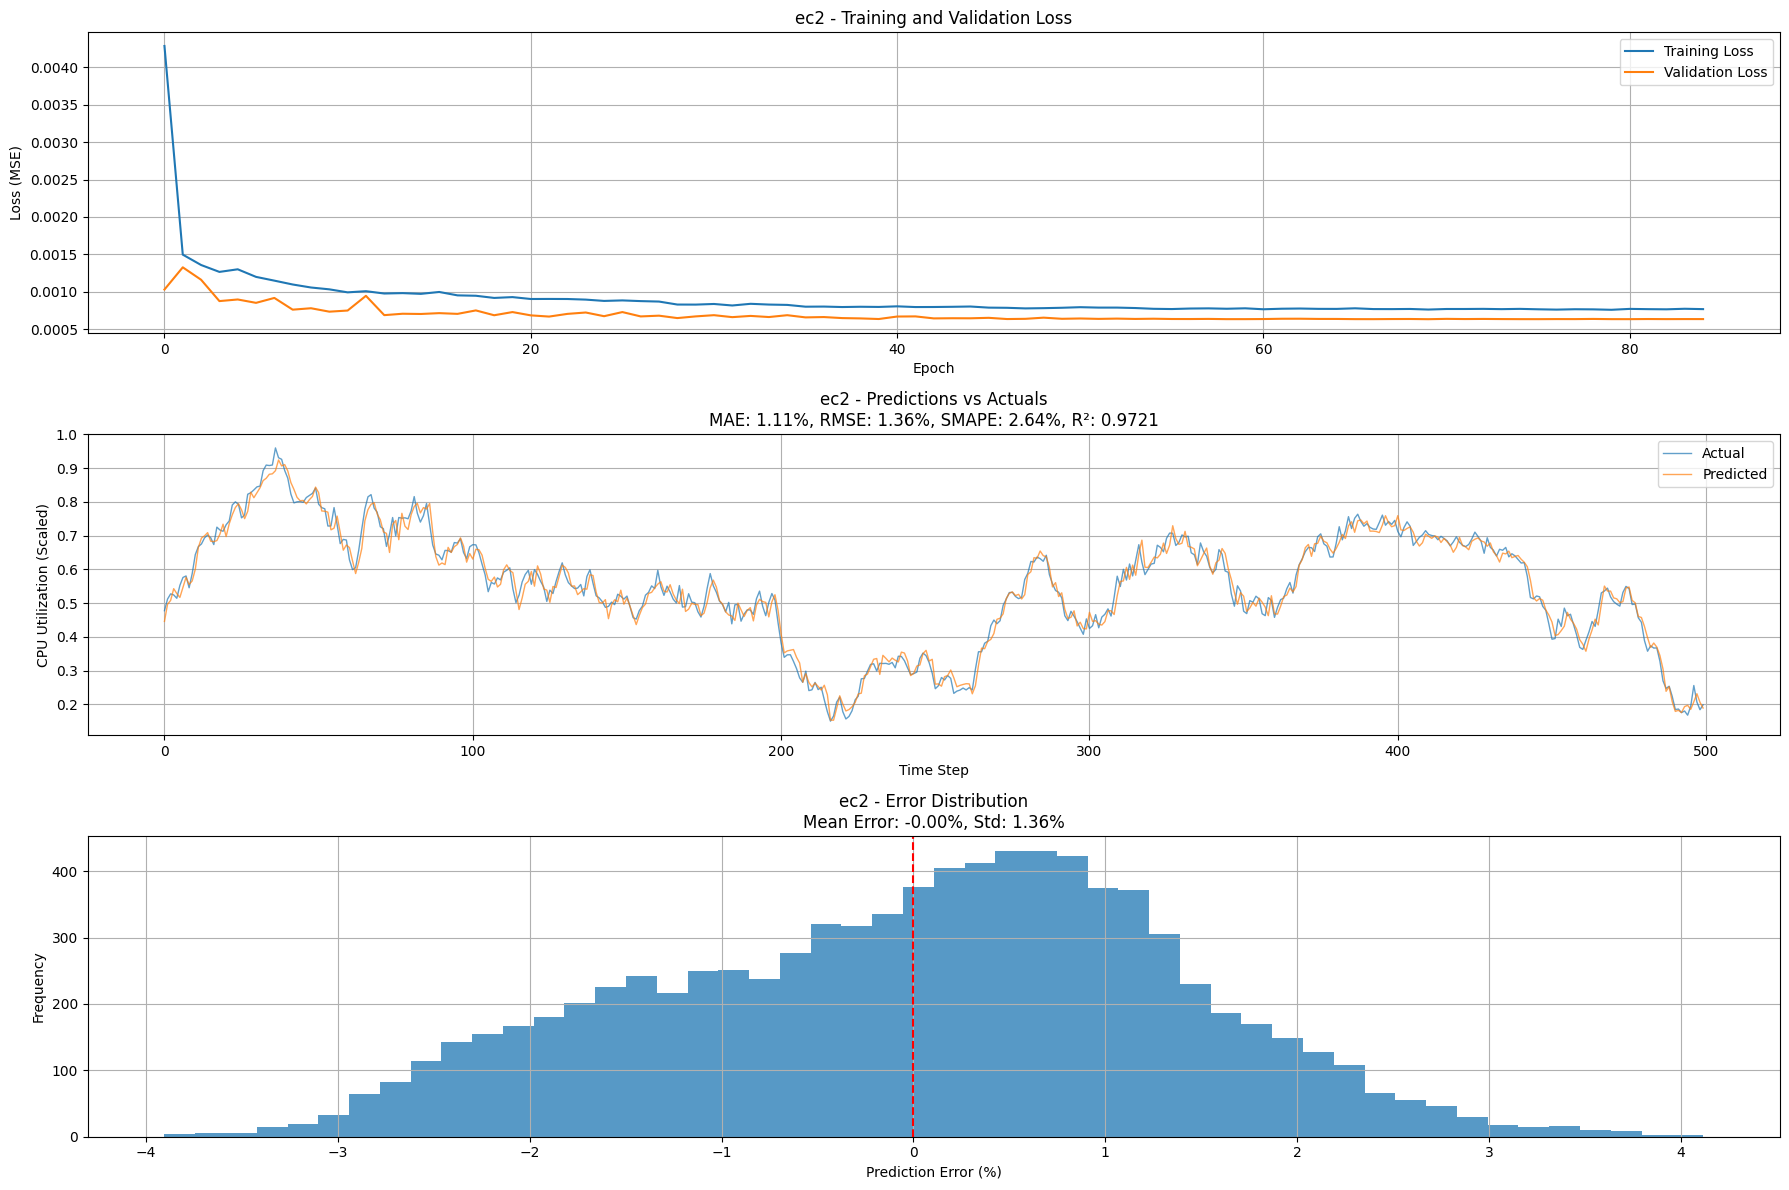


EC2 model training complete.
Model saved as ec2_lstm_model.pth
Scalers saved as ec2_scalers.pkl

Generating future predictions...


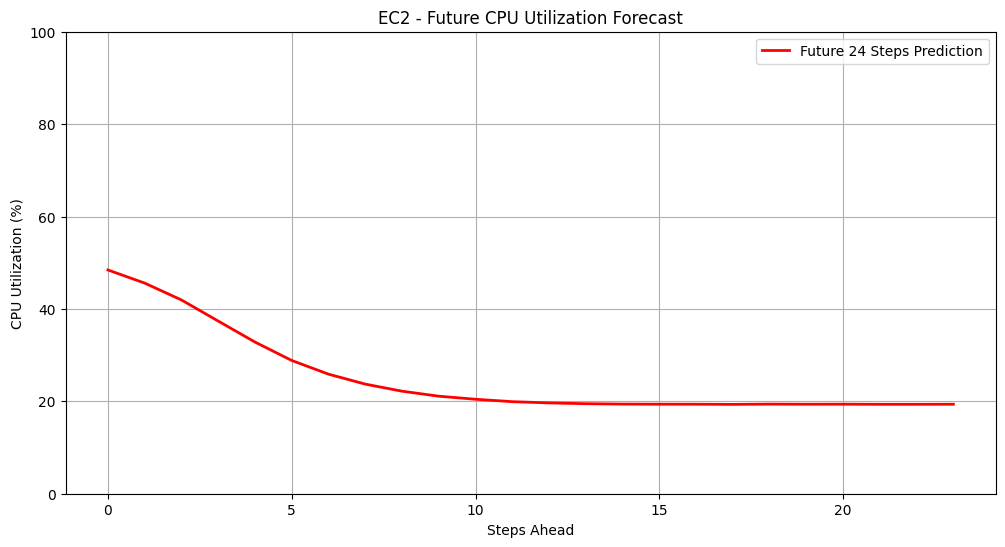


Processing RDS data...
Loading data from /content/rds_metrics.csv
Shape after preprocessing: (43200, 4)
Index has NaT: False
Dropped 24 rows containing NaN values in data columns
Performing feature importance analysis...
Top most important features:
                             feature  importance
3           RDS_CPUUtilization_lag_1    0.943293
8          RDS_CPUUtilization_diff_1    0.056415
11   RDS_CPUUtilization_roll_1H_mean    0.000029
12    RDS_CPUUtilization_roll_1H_std    0.000015
4           RDS_CPUUtilization_lag_3    0.000012
14    RDS_CPUUtilization_roll_3H_std    0.000012
9          RDS_CPUUtilization_diff_3    0.000011
6          RDS_CPUUtilization_lag_12    0.000010
10         RDS_CPUUtilization_diff_6    0.000010
30      RDS_CPUUtilization_q90.0_24H    0.000009
20   RDS_CPUUtilization_roll_24H_std    0.000009
18   RDS_CPUUtilization_roll_12H_std    0.000009
16    RDS_CPUUtilization_roll_6H_std    0.000008
39                  day_of_month_sin    0.000008
34            

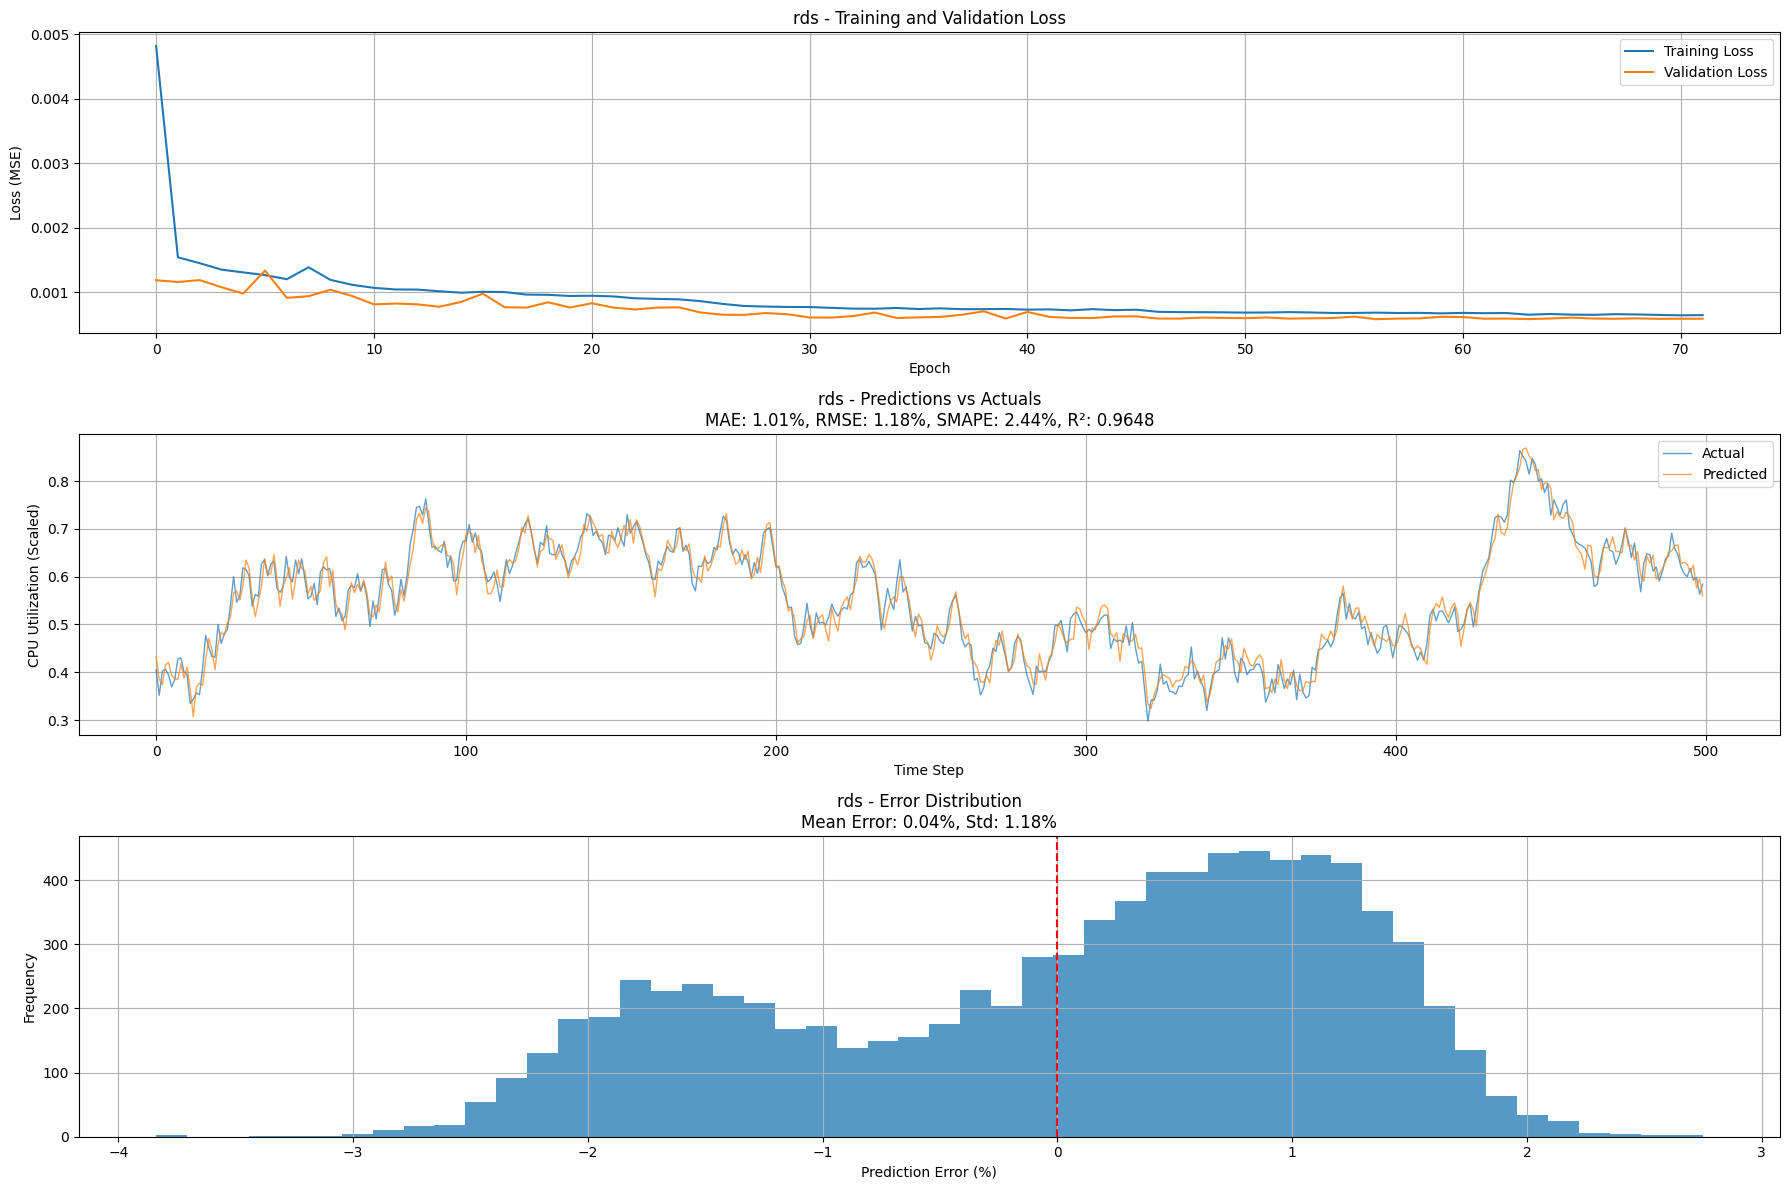


RDS model training complete.
Model saved as rds_lstm_model.pth
Scalers saved as rds_scalers.pkl

Generating future predictions...


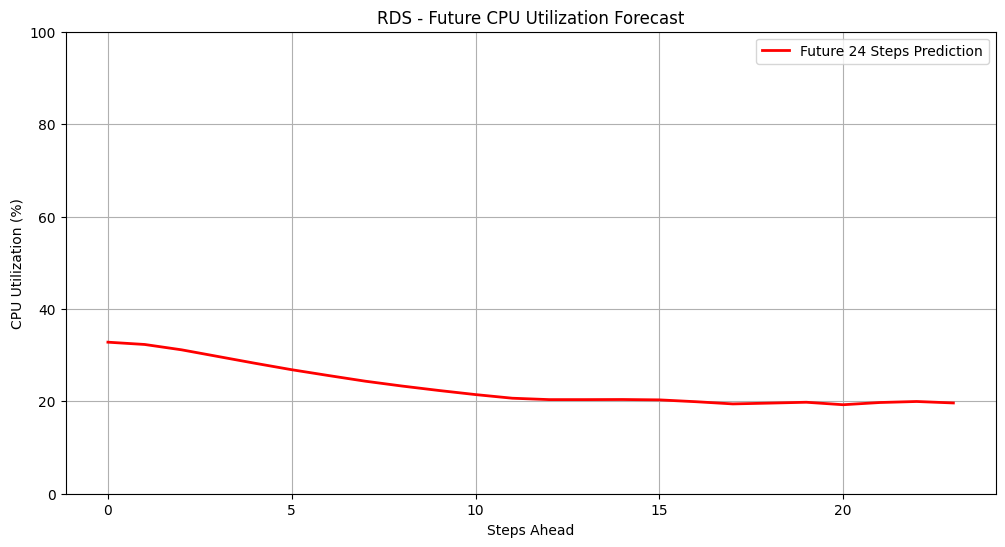


Processing ECS data...
Loading data from /content/ecs_metrics.csv
Shape after preprocessing: (43200, 4)
Index has NaT: False
Dropped 24 rows containing NaN values in data columns
Performing feature importance analysis...
Top most important features:
                             feature  importance
3           ECS_CPUUtilization_lag_1    0.984003
8          ECS_CPUUtilization_diff_1    0.015881
32                ECS_CPU_Task_Ratio    0.000017
20   ECS_CPUUtilization_roll_24H_std    0.000007
9          ECS_CPUUtilization_diff_3    0.000005
4           ECS_CPUUtilization_lag_3    0.000004
16    ECS_CPUUtilization_roll_6H_std    0.000004
12    ECS_CPUUtilization_roll_1H_std    0.000004
18   ECS_CPUUtilization_roll_12H_std    0.000004
14    ECS_CPUUtilization_roll_3H_std    0.000004
33             ECS_CPU_Network_Ratio    0.000003
38                  day_of_month_sin    0.000003
10         ECS_CPUUtilization_diff_6    0.000003
26      ECS_CPUUtilization_q10.0_24H    0.000003
0             

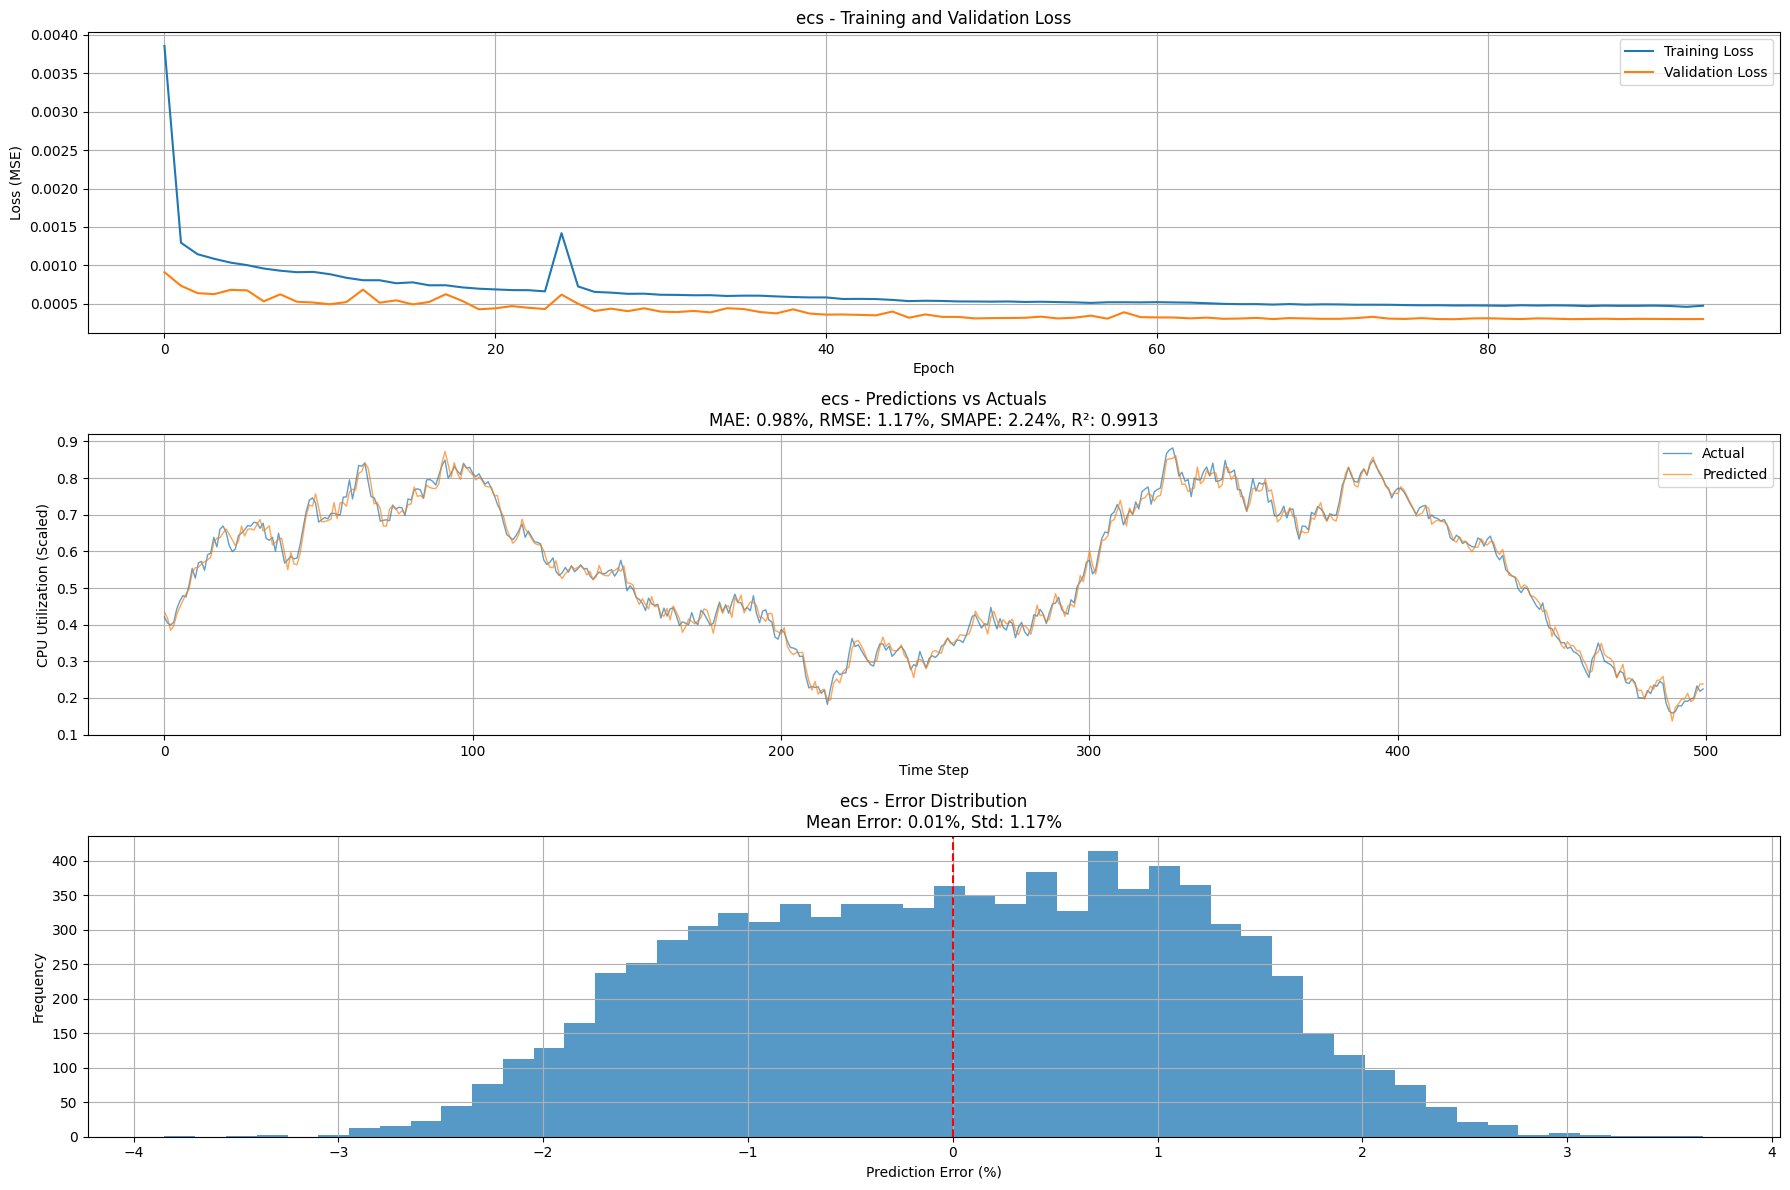


ECS model training complete.
Model saved as ecs_lstm_model.pth
Scalers saved as ecs_scalers.pkl

Generating future predictions...


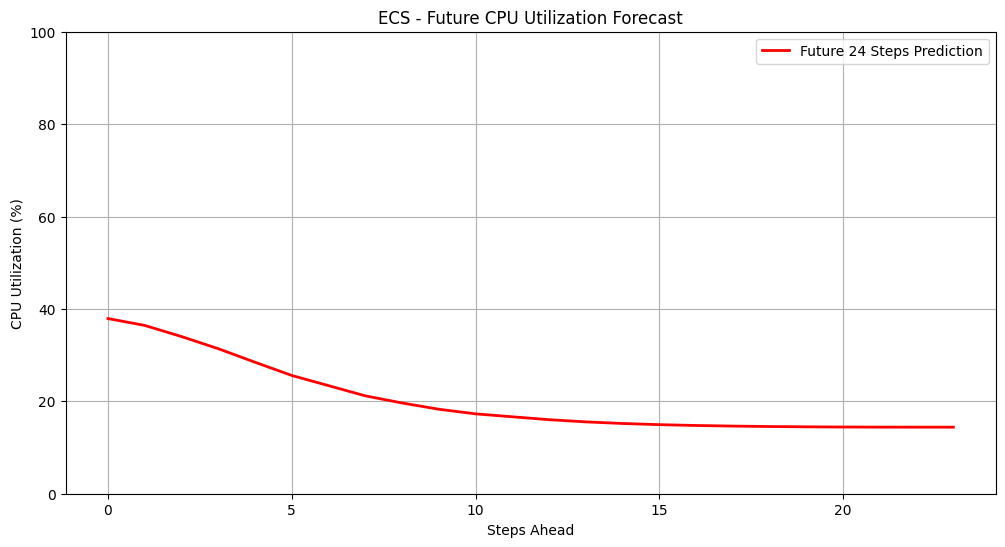


Training completed successfully for:
- EC2
- RDS
- ECS


In [ ]:
def run_lstm_pipeline(file_path, service_type, target_col):
    print(f"\n{'='*50}")
    print(f"Processing {service_type.upper()} data...")
    print(f"{'='*50}")

    try:
        # Data loading and preprocessing
        df = load_and_preprocess(file_path)
        df = add_features(df, service_type)

        X_train, y_train, X_val, y_val, feature_scaler, target_scaler = prepare_data_for_lstm(df, target_col)
        print(f"\nData shapes:")
        print(f"Training data: {X_train.shape}")
        print(f"Validation data: {X_val.shape}")

        train_dataset = TimeSeriesDataset(X_train, y_train, augment=True)
        val_dataset = TimeSeriesDataset(X_val, y_val)

        batch_size = min(64, max(16, len(train_dataset) // 100))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Model configuration
        input_size = X_train.shape[2]
        hidden_size = 128  
        num_layers = 2   
        output_size = 1
        dropout_rate = 0.3

        model = LSTM(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)

        # Loss function
        def weighted_mse_loss(input, target):
          weights = torch.where(target < 0.1, 5.0, 1.0) 
          return (weights * (input - target) ** 2).mean()

        criterion = weighted_mse_loss
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

        # Training
        print(f"\nTraining {service_type.upper()} model on {device}...")
        num_epochs = 150
        patience = 15
        model, train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion,
            optimizer, num_epochs, scheduler, patience
        )

        # Evaluation
        print(f"\nEvaluating {service_type.upper()} model...")
        test_loss, predictions, actuals, metrics = evaluate_model(
            model, val_loader, criterion, target_scaler
        )

        # Plot results
        plot_results(train_losses, val_losses, predictions, actuals, service_type, metrics)

        # Save model and scalers
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout': dropout_rate,
            'metrics': metrics
        }, f'{service_type}_lstm_model.pth')

        with open(f'{service_type}_lstm_model_scalers.pkl', 'wb') as f:
            pickle.dump({
                'feature_scaler': feature_scaler,
                'target_scaler': target_scaler
            }, f)

        print(f"\n{service_type.upper()} model training complete.")
        print(f"Model saved as {service_type}_lstm_model.pth")
        print(f"Scalers saved as {service_type}_lstm_model_scalers.pkl")

        # Future predictions
        print("\nGenerating future predictions...")
        last_sequence = X_val[-1].cpu().numpy()
        future_steps = 24
        future_preds = forecast_future(model, last_sequence, feature_scaler, target_scaler, future_steps)

        plt.figure(figsize=(12, 6))
        plt.plot(range(future_steps), future_preds, 'r-', linewidth=2,
                label=f'Future {future_steps} Steps Prediction')
        plt.title(f'{service_type.upper()} - Future CPU Utilization Forecast')
        plt.xlabel('Steps Ahead')
        plt.ylabel('CPU Utilization (%)')
        plt.ylim(0, 100) 
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{service_type}_future_forecast.png', dpi=300)
        plt.show()

        return model, (feature_scaler, target_scaler)

    except Exception as e:
        print(f"\nERROR processing {service_type.upper()}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Main execution
if __name__ == "__main__":
    services = [
        {'file': '/content/ec2_metrics.csv', 'type': 'ec2', 'target': 'EC2_CPUUtilization'},
        {'file': '/content/rds_metrics.csv', 'type': 'rds', 'target': 'RDS_CPUUtilization'},
        {'file': '/content/ecs_metrics.csv', 'type': 'ecs', 'target': 'ECS_CPUUtilization'}
    ]

    models = {}
    scalers = {}

    for service in services:
        model, scaler = run_lstm_pipeline(service['file'], service['type'], service['target'])
        if model is not None:
            models[service['type']] = model
            scalers[service['type']] = scaler

    if models:
        print("\nTraining completed successfully for:")
        for service_type in models.keys():
            print(f"- {service_type.upper()}")
    else:
        print("\nNo models were successfully trained.")